## Lab 4: Gridded data in Python

**Objectives:**
   * We will learn how to read, inspect, and write gridded data using <code>rasterio</code> and <code>xarray</code>.
   * Learn how to index, slice and manipulate our gridded data.
   * Export our data as <code>GeoTIFF</code> or <code>NetCDF</code> format.

We will start by reading/writing some remote sensing data where each band is saved as separate <code>GeoTIFFs</code>. After that, we will read some climate reanalysis data saved as <code>NetCDF</code> format.

In [1]:
# Import packages
import os
import glob

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import geopandas as gpd
import rasterio
import rioxarray
import xarray

### Read and inspect a Landsat 8 raster layer

In [2]:
# Define filepath
filepath = 'E:/GitHub/GeospatialDataAnalysis/geospatial-data-science/labs/lab4/'

# Define list of Landsat bands
files = sorted(glob.glob(filepath + 'landsat/*.tif'))
print(files)

['E:/GitHub/GeospatialDataAnalysis/geospatial-data-science/labs/lab4/landsat\\LC08_L2SP_047029_20200814_20210330_02_T1_SR_B1.tif', 'E:/GitHub/GeospatialDataAnalysis/geospatial-data-science/labs/lab4/landsat\\LC08_L2SP_047029_20200814_20210330_02_T1_SR_B2.tif', 'E:/GitHub/GeospatialDataAnalysis/geospatial-data-science/labs/lab4/landsat\\LC08_L2SP_047029_20200814_20210330_02_T1_SR_B3.tif', 'E:/GitHub/GeospatialDataAnalysis/geospatial-data-science/labs/lab4/landsat\\LC08_L2SP_047029_20200814_20210330_02_T1_SR_B4.tif', 'E:/GitHub/GeospatialDataAnalysis/geospatial-data-science/labs/lab4/landsat\\LC08_L2SP_047029_20200814_20210330_02_T1_SR_B5.tif', 'E:/GitHub/GeospatialDataAnalysis/geospatial-data-science/labs/lab4/landsat\\LC08_L2SP_047029_20200814_20210330_02_T1_SR_B6.tif', 'E:/GitHub/GeospatialDataAnalysis/geospatial-data-science/labs/lab4/landsat\\LC08_L2SP_047029_20200814_20210330_02_T1_SR_B7.tif', 'E:/GitHub/GeospatialDataAnalysis/geospatial-data-science/labs/lab4/landsat\\rgb.tif']


In [28]:
# Open a single band
src = rasterio.open(files[0])
band_1 = src.read(1)

# Find metadata (e.g. driver, data type, coordinate reference system, transform etc.)
print(src.profile)

# Get corners of dataset
full_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
print(full_extent)


{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 1208, 'height': 1422, 'count': 1, 'crs': CRS.from_epsg(32610), 'transform': Affine(30.0, 0.0, 391695.0,
       0.0, -30.0, 4880565.0), 'tiled': False, 'interleave': 'band'}
[391695.0, 427935.0, 4837905.0, 4880565.0]


In [29]:
# Find coordinate reference system
src.crs # https://epsg.io/32610

CRS.from_epsg(32610)

In [30]:
# Find format
src.driver

'GTiff'

In [33]:
# Find pixel size
src.transform[0]


30.0

In [34]:
# Find bounds of dataset
src.bounds

BoundingBox(left=391695.0, bottom=4837905.0, right=427935.0, top=4880565.0)

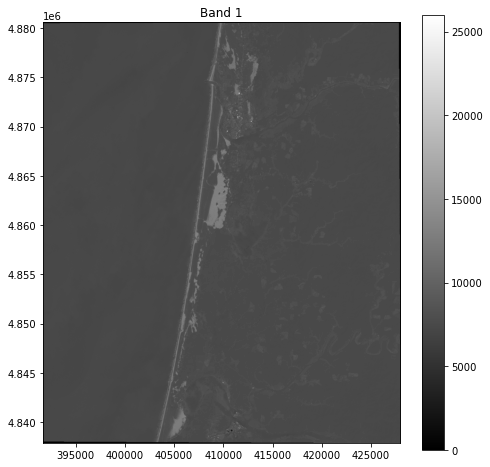

In [5]:
# Plot dataset
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(band_1, cmap='gray', extent=full_extent)
ax.set_title("Band 1")
fig.colorbar(im, orientation='vertical')
plt.show()

Since the raster is read as an NumPy array (called <code>band_1</code>), we can use standard Python methods to find the dimensions, shape, and size of it.

***********
## Question 1 (20 points): 

Write a script that displays this Landsat data as as:

* a) a **color infrared composite** (i.e. bands 5, 4, 3)

************

### Color Infrared Composite image from multiple Landsat 8 bands

In [6]:
# Open all bands in a loop
list_bands = []
for file in files:
    # Read band
    src = rasterio.open(file)
    band = src.read(1)
    
    # Append to list
    list_bands.append(band)
""
# Convert from list of arrays to n-dimensional array
all_bands = np.dstack(list_bands)

In [7]:
all_bands.shape

(1422, 1208, 8)

We can actually pass a 3-band array to imshow and plot it as an RGB image because it is such a common image format. See [doc here](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.imshow.html) for (M, N, 3) array input. But first we have to convert our values so they have a range of 0-255. We will also produce a new NumPy array that represents just the Red, Green, and Blue bands using the following as a guide: https://www.usgs.gov/media/images/landsat-8-band-designations.

In [8]:
# Convert values to a range of 0-255
all_bands_image = np.uint8((all_bands / 65536) * 255)

In [16]:
# Produce a new array by stacking the RGB bands
inf = np.dstack((all_bands_image[:,:,4],all_bands_image[:,:,3],all_bands_image[:,:,2]))

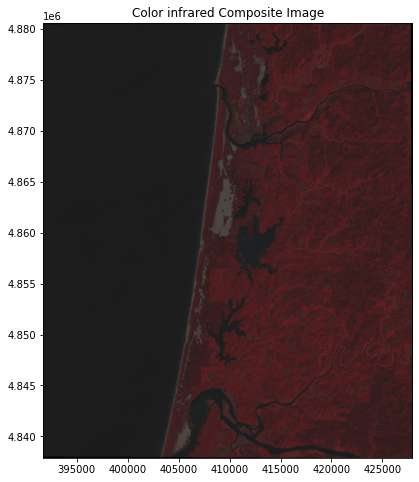

In [17]:
# Plot as RGB image
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(rgb, extent=full_extent)
ax.set_title("Color infrared Composite Image")
plt.show()

***********
## Question 1 (20 points): 

Write a script that displays this Landsat data as as:

* b) an **NDVI** image (i.e. (Band 5 - Band 4) / (Band 5 + Band 4))

************

### Compute a band ratio to produce an NDVI image

We can compute a Normalized Difference Vegetation Index (NDVI) using the Green and NIR bands. 

NDWI = (Band 5 - Band 4) / (Band 5 + Band 4)

Remember that arrays are zero indexed, so the first layer is corresponds to <code>all_bands[:,:,0]</code>. Also note that we have to make sure our bands are converted to <code>float</code> datatypes.

In [11]:
# Compute NDWI
ndvi = np.divide((all_bands[:,:,4].astype(float) - all_bands[:,:,3].astype(float)), \
                 (all_bands[:,:,4].astype(float) + all_bands[:,:,3].astype(float)))

C:\Users\brdeh\AppData\Local\Temp\ipykernel_19492\535613668.py:2: RuntimeWarning: invalid value encountered in true_divide
  ndvi = np.divide((all_bands[:,:,4].astype(float) - all_bands[:,:,3].astype(float)), \


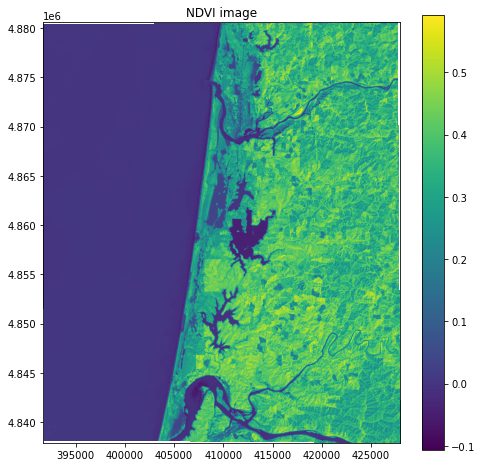

In [13]:
# Plot NDVI image
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(ndvi, extent=full_extent)
ax.set_title("NDVI image")
fig.colorbar(im, orientation='vertical')
plt.show()

We can now see which pixels are likely to be ocean, rivers, or lakes.

### Write true color composite to GeoTIFF

In [14]:
# Write an array as a raster band to a new 8-bit file. For the new file's profile, 
# we start with the profile of the source
profile = src.profile

# And then change the band count to 3, set the dtype to uint8, and specify LZW compression.
profile.update(dtype=rasterio.uint8, count=3, compress='lzw')

In [18]:
with rasterio.open(filepath + 'landsat/rgb.tif', 'w', **profile) as dst:
    # Write array
    dst.write(np.rollaxis(inf, axis=2)) # Note that array needs to be in bands, rows, cols order (z, y, x)

CPLE_AppDefinedError: Deleting E:/GitHub/GeospatialDataAnalysis/geospatial-data-science/labs/lab4/landsat/rgb.tif failed: Permission denied

*******
## Question 2 (10 points):

Write a script to find:

* a) the air temperature (in F) and cloud cover (in %) in Florence, OR (in 2020) on January 31, 2020?
* b) the air temperature (in F) and cloud cover (in %) in **Eugene, OR** (in 2020) on January 31, 2020?

**********


### Read climate reanalysis data

We usually use the <code>netCDF4</code> or <code>xarray</code> packages for this task.

In [26]:
# Read data
xds = xarray.open_dataset('E:/GitHub/GeospatialDataAnalysis/geospatial-data-science/labs/lab4/era/usa_t2m_cloud_2020.nc', decode_coords='all')

FileNotFoundError: [Errno 2] No such file or directory: 'E:\\GitHub\\GeospatialDataAnalysis\\geospatial-data-science\\labs\\lab4\\era\\usa_t2m_cloud_2020.nc'

In [25]:
filepath + 'era/usa_t2m_cloud_2020.nc'

'E:/GitHub/GeospatialDataAnalysis/geospatial-data-science/labs/lab4/era/usa_t2m_cloud_2020.nc'

In [ ]:
xds

This looks a bit overwelming but it nice way to store gridded data. Below is a schematic of what an xarray data structure represents.

<div>
<img src="images/xarray_data_structures.png" width="600"/>
</div>

In [ ]:
# Print the time period of the data
print('The data ranges from %s to %s' %(xds['t2m']['time'].values.min(), xds['t2m']['time'].values.max()))

So we know the data spans one year but there are 1464 dimensions in the time variable. This means that the reanalysis data must have a temporal resolution of 6 hours. So before we continue we will resample to daily temporal resolution.

In [ ]:
xds_daily = xds.resample(time='1D').mean()
xds_daily

### Plot climate reanalysis data

Now each layer in the dataset corresponds to a single day. Let's plot the air temperature and cloud cover for the day which the Landsat image was acquired (August 14, 2020).

In [ ]:
# Plot data
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
im1 = ax1.imshow(xds_daily['t2m'][226,:,:])
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

im2 = ax2.imshow(xds_daily['tcc'][226,:,:])
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

### Weather in Florence, OR

So we know that is was relatively cold, cloud-free day in Florence, just like we see in the Landsat image. But how anomalous were these conditions? We can investigate by finding the nearest climate reanalysis grid cell to Florence, OR. First we will define the latitude and longitude of Florence. 

In [ ]:
lat, lon = 43.974659, -124.103142

In [ ]:
# Next, find the index of the grid point nearest a specific lat/lon.   
abslat = np.abs(xds_daily['latitude'] - lat)
abslon = np.abs(xds_daily['longitude'] - lon)
c = np.maximum(abslon, abslat)

([xloc], [yloc]) = np.where(c == np.min(c))

In [ ]:
print('Cloud cover in Florence on Aug 14, 2020 = %.2f %%' % (xds_daily['tcc'][226, yloc, xloc].values * 100))

In [ ]:
fahrenheit = (xds_daily['t2m'][226, yloc, xloc].values - 273.15) * 9/5 + 32
print('Air temperature in Florence on Aug 14, 2020 = %.2f F' % (fahrenheit))

### Plot time series

These values look about right. Now we can plot the time series.

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1.plot(xds_daily['t2m'][:, yloc, xloc])
ax1.scatter(226, xds_daily['t2m'][226, yloc, xloc], s=50, color='r')
ax1.set_xlabel('Day of year', fontsize=14)
ax1.set_ylabel('Air temperature (K)', fontsize=14)

ax2.plot(xds_daily['tcc'][:, yloc, xloc])
ax2.scatter(226, xds_daily['tcc'][226, yloc, xloc], s=50, color='r')
ax2.set_xlabel('Day of year', fontsize=14)
ax2.set_ylabel('Cloud cover (%)', fontsize=14)

### Find mean values

It was a pretty nice warm day in Florence on Aug 14, 2020 relative to mean annual conditions. But what is the actual mean?

In [ ]:
mean_temp = (xds_daily['t2m'][:, yloc, xloc].mean() - 273.15) * 9/5 + 32
print('Mean air temp. in Florence in 2020 = %.2f F' % (mean_temp))

In [ ]:
mean_cloud = xds_daily['tcc'][:, yloc, xloc].mean()
print('Mean cloud cover in Florence in 2020 = %.2f %%' % (mean_cloud * 100))

Finally, let's calculate how many days had less than 20% cloud cover in Florence

In [ ]:
days = np.sum(xds_daily['tcc'][:, yloc, xloc] < 0.2).values
print('There were %.0f days with less than 20%% cloud cover in 2020' % days)

**********

## Question 3 (20 points): 

Write a script to find the following grid cells in the climate reanalysis dataset and provide a rough location of where they are located. You can use the following link to convert your lat/lons to an address: https://www.latlong.net/Show-Latitude-Longitude.html

* a) Highest average air temperature (i.e. hottest place)
* b) Lowest average air temperature (i.e. coldest place)
* c) Highest average cloudiness (i.e. cloudiest place)
* d) Lowest average cloudiest (i.e. least cloudy place)
* e) Place with highest range in air temperature
* f) Place with the absolute coldest temperature on a single day 
*********

## Remember to submit your answers to Questions 1, 2 and 3 **by Friday 11:59pm**

In [ ]:
# HINT use argmax() or argmin()
max_value = np.mean(xds_daily['t2m'], axis=0).argmax()
index = np.unravel_index(max_value, np.mean(xds_daily['t2m'], axis=0).shape)